Neo4J v054 - Sample Based Analysis
================

## Set up the environment


### Install py2neo for querying Neo4J 

In [149]:
#!pip3 install py2neo

### Import Packages

In [150]:
from py2neo import Graph
import pandas as pd
import numpy as np
import subprocess
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Load Neo4J DB

In [151]:
graph = Graph("bolt://10.138.0.53:7687", auth=("neo4j", "bZjcc1XTd71ft2oVGj7A8aU8UkttdBhRAecV4x6USC3wpeOLmCmfCAH2bAMllQQlwtzCbzLuX1TgoX-Enc7MUA"))

## Generate Sample Status Table

### The number of nodes (Fastq, Ubam, Vcf, Cram, Crai) 

In [152]:
# Fastq
query = "Match (j:Json:FromPersonalis), (f:Fastq) WHERE f.sample = j.sample RETURN j.sample AS sample, count(f) AS fastq"
num_fastq = graph.run(query).to_data_frame()
num_fastq.set_index('sample')

# Ubam
query = "Match (j:Json:FromPersonalis), (u:Ubam) WHERE u.sample = j.sample RETURN DISTINCT j.sample AS sample, count(u) AS ubam"
num_ubam = graph.run(query).to_data_frame()
num_ubam.set_index('sample')

# Vcf
query = "Match (j:Json:FromPersonalis), (v:Merged:Vcf) WHERE v.sample = j.sample RETURN DISTINCT j.sample AS sample, count(v) AS vcf"
num_vcf = graph.run(query).to_data_frame()
num_vcf.set_index('sample')

# Cram
query = "Match (j:Json:FromPersonalis), (cm:Cram) WHERE cm.sample = j.sample RETURN DISTINCT j.sample AS sample, count(cm) AS cram"
num_cram = graph.run(query).to_data_frame()
num_cram.set_index('sample')

# Crai
query = "Match (j:Json:FromPersonalis), (ci:Crai) WHERE ci.sample = j.sample RETURN DISTINCT j.sample AS sample, count(ci) AS crai"
num_crai = graph.run(query).to_data_frame()
num_crai.set_index('sample')
print("")

### The number of jobs (FQ2U, GATK) 

In [153]:
# Fq2u
query = "Match (j:Json:FromPersonalis), (e:Job:Dsub {name:'fastq-to-ubam'}) WHERE e.sample = j.sample RETURN j.sample AS sample, count(e) AS fq2u"
num_fq2u = graph.run(query).to_data_frame()
num_fq2u.set_index('sample')

# Gatk
query = "Match (j:Json:FromPersonalis), (g:Job:CromwellWorkflow) WHERE g.sample = j.sample RETURN j.sample AS sample, count(g) AS gatk"
num_gatk = graph.run(query).to_data_frame()
num_gatk.set_index('sample')
print("")

### Merge all node and job dfs to one df

In [154]:
#-- only nodes
#sample_qc_df=num_fastq.merge(num_ubam, how='outer').merge(num_vcf, how='outer').merge(num_cram, how='outer').merge(num_crai, how='outer')
#columnlist=["sample","fastq","ubam","vcf","cram","crai"]

#-- nodes and jobs
sample_qc_df=num_fastq.merge(num_ubam, how='outer').merge(num_vcf, how='outer').merge(num_cram, how='outer').merge(num_crai, how='outer').merge(num_fq2u,how='outer').merge(num_gatk,how='outer')
columnlist=["sample","fastq","ubam","vcf","cram","crai","fq2u","gatk"]
numsample=len(sample_qc_df)
print("The number of samples : " + str(numsample) + "\n")

sample_qc_df=sample_qc_df[columnlist]
sample_qc_df.fillna(0,inplace=True)
#sample_qc_df.head(3)

The number of samples : 662



### Classification based on sample status and success.

In [155]:
##-- Passed

#- 1. Successful jobs
sample_qc_df.loc[(sample_qc_df['ubam']==sample_qc_df['fastq']/2)&(sample_qc_df['vcf']==1)&(sample_qc_df['cram']==1) \
                                   &(sample_qc_df['crai']==1)&(sample_qc_df['fq2u']==sample_qc_df['fastq']/2)&(sample_qc_df['gatk']==1),'status']="success"
#- 2. Duplicated jobs
sample_qc_df.loc[(sample_qc_df['ubam']==sample_qc_df['fastq']/2)&(sample_qc_df['vcf']==1)&(sample_qc_df['cram']==1) \
                                   &(sample_qc_df['crai']==1)&((sample_qc_df['fq2u']>sample_qc_df['fastq']/2)|(sample_qc_df['gatk']>1)),'status']="duplicated jobs"
#- 3. Duplicated jobs and nodes
sample_qc_df.loc[((sample_qc_df['ubam']>sample_qc_df['fastq']/2)|(sample_qc_df['vcf']>1)|(sample_qc_df['cram']>1) \
                                 |(sample_qc_df['crai']>1))&((sample_qc_df['fq2u']>=sample_qc_df['fastq']/2)|(sample_qc_df['gatk']>=1)),'status']="duplicated nodes"
#- Success 
sample_qc_df.loc[(sample_qc_df['status'].isin(["success", "duplicated jobs", "duplicated nodes"])), 'success'] = "pass"


##-- failed

#- 4. failed fq2u jobs
sample_qc_df.loc[((sample_qc_df['ubam']<sample_qc_df['fastq']/2)&(sample_qc_df['vcf']==0)&(sample_qc_df['cram']==0) \
                                   &(sample_qc_df['crai']==0))&((sample_qc_df['fq2u']>=sample_qc_df['fastq']/2)|(sample_qc_df['gatk']==0)),'status']="failed fq2u"
#- 5. failed gatk jobs
sample_qc_df.loc[(sample_qc_df['ubam']==sample_qc_df['fastq']/2)&((sample_qc_df['vcf']<1)|(sample_qc_df['cram']<1) \
                                   |(sample_qc_df['crai']<1))&((sample_qc_df['fq2u']>=sample_qc_df['fastq']/2)&(sample_qc_df['gatk']>=1)),'status']="failed gatk"
#- 6. no gatk jobs
sample_qc_df.loc[((sample_qc_df['ubam']==sample_qc_df['fastq']/2)&(sample_qc_df['vcf']==0)&(sample_qc_df['cram']==0) \
                                   &(sample_qc_df['crai']==0))&((sample_qc_df['fq2u']>=sample_qc_df['fastq']/2)&(sample_qc_df['gatk']==0)),'status']="no gatk"
#- Fail
sample_qc_df.loc[(sample_qc_df['status'].isin(["failed fq2u", "failed gatk", "no gatk"])), 'success'] = "fail"

##-- Check unclassified samples.
num_unclassified = len(sample_qc_df[sample_qc_df.status.isna()==True])
print("The number of unclassified samples : " + str(num_unclassified)+"\n")

if num_unclassified != 0 :
    display(sample_qc_df[sample_qc_df.status.isna()==True])
    

The number of unclassified samples : 0



In [156]:
##-- Display of this table
pd.set_option('display.float_format', lambda x: '%.f' % x)

display(sample_qc_df[sample_qc_df['status']=='success'].head(2))
display(sample_qc_df[sample_qc_df['status']=='duplicated jobs'].head(10))
display(sample_qc_df[sample_qc_df['status']=='duplicated nodes'].head(20))
display(sample_qc_df[sample_qc_df['status']=='failed fq2u'].head(2))
display(sample_qc_df[sample_qc_df['status']=='no gatk'].head(2))
display(sample_qc_df[sample_qc_df['status']=='failed gatk'].head(2))

,sample,fastq,ubam,vcf,cram,crai,fq2u,gatk,status,success


,sample,fastq,ubam,vcf,cram,crai,fq2u,gatk,status,success
11,SHIP4946379,8,4,1,1,1,8,1,duplicated jobs,pass
12,SHIP4948528,8,4,1,1,1,8,1,duplicated jobs,pass
13,SHIP4946378,8,4,1,1,1,8,1,duplicated jobs,pass
14,SHIP4948527,8,4,1,1,1,8,1,duplicated jobs,pass
15,SHIP4946380,8,4,1,1,1,8,1,duplicated jobs,pass
16,SHIP4946381,8,4,1,1,1,8,1,duplicated jobs,pass
17,SHIP4946382,8,4,1,1,1,8,1,duplicated jobs,pass
18,SHIP4948525,8,4,1,1,1,8,1,duplicated jobs,pass
19,SHIP4948526,8,4,1,1,1,8,1,duplicated jobs,pass
20,SHIP4948529,8,4,1,1,1,8,1,duplicated jobs,pass


,sample,fastq,ubam,vcf,cram,crai,fq2u,gatk,status,success
0,SHIP4946367,8,4,3,4,4,4,14,duplicated nodes,pass
1,SHIP4946368,8,4,2,3,3,4,4,duplicated nodes,pass
2,SHIP4946369,8,4,3,4,4,4,7,duplicated nodes,pass
3,SHIP4946371,8,4,3,3,3,4,5,duplicated nodes,pass
4,SHIP4946372,8,4,3,4,4,4,5,duplicated nodes,pass
5,SHIP4946370,8,5,3,4,4,5,6,duplicated nodes,pass
6,SHIP4946373,8,4,3,3,3,4,4,duplicated nodes,pass
7,SHIP4946375,8,4,2,4,4,4,7,duplicated nodes,pass
8,SHIP4946374,8,4,3,4,4,4,5,duplicated nodes,pass
9,SHIP4946376,8,4,3,4,4,4,5,duplicated nodes,pass


,sample,fastq,ubam,vcf,cram,crai,fq2u,gatk,status,success
322,SHIP5142463,8,0,0,0,0,0,0,failed fq2u,fail
323,SHIP5142426,8,0,0,0,0,0,0,failed fq2u,fail


,sample,fastq,ubam,vcf,cram,crai,fq2u,gatk,status,success


,sample,fastq,ubam,vcf,cram,crai,fq2u,gatk,status,success
280,SHIP5141926,8,4,0,0,0,8,1,failed gatk,fail
282,SHIP5141900,8,4,0,0,0,8,3,failed gatk,fail


## Generate Status Table

### The number of samples by status and success

In [157]:
stat_status_qc=sample_qc_df['status'].value_counts().to_frame()
stat_status_qc['rate']=100*(stat_status_qc['status']/numsample)

stat_status_qc=stat_status_qc.reindex(index = ['success', 'duplicated jobs', 'duplicated nodes', 'failed fq2u', 'no gatk', 'failed gatk'])
stat_status_qc=stat_status_qc.replace(np.nan,0)
display(stat_status_qc)

pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("Success Rate : " + str(sum(stat_status_qc['rate'][0:3])) + "%")
print("Failed Rate : " + str(sum(stat_status_qc['rate'][3:6])) + "%")

,status,rate
success,0,0
duplicated jobs,129,19
duplicated nodes,191,29
failed fq2u,340,51
no gatk,0,0
failed gatk,2,0


Success Rate : 48.33836858006042%
Failed Rate : 51.66163141993958%


## Check the relationship informaiton and dstat message of successful samples

### fq2u issued relationship of successful samples

In [158]:
success_sample_df = sample_qc_df[sample_qc_df['status']=='success']
print("The number of success samples: " + str(len(success_sample_df)))
success_sample=success_sample_df['sample'].to_list()

query = "Match (:Fastq)-[:INPUT_TO]->(j:Job:Dsub) WHERE not (j)-[:OUTPUT]->(:Ubam) and j.sample IN {} RETURN distinct j.sample AS sample_no_fq2utoubam".format(str(success_sample))
norelation_ubam = graph.run(query).to_data_frame()
print("The number of samples without the relationship between fq2u and ubam: " + str(len(norelation_ubam)))
print("\n")

display(norelation_ubam.head(3))

The number of success samples: 0
The number of samples without the relationship between fq2u and ubam: 0




""


### gatk issued relationship of successful samples

In [159]:
# success_sample_df = sample_qc_df[sample_qc_df['status']=='success']
# print("The number of success samples: " + str(len(success_sample_df)))
# success_sample=norelation_sample_df['sample'].to_list()

query = "Match (j:Job:Cromewell) WHERE (not (:Ubam)-[:INPUT_TO]->(j) or not (j)-[:OUTPUT]->(:Merged:Vcf) or not (j)-[:OUTPUT]->(:Cram) or not (j)-[:OUTPUT]->(:Crai)) and (j.sample IN {}) RETURN distinct j.sample AS sample_missed_output".format(str(success_sample))
norelation_output = graph.run(query).to_data_frame()
print("The number of samples without the relationship between gatk and outputs: " + str(len(norelation_output)))

display(norelation_output.head(3))
#display(set(norelation_sample)-set(norelation_dstat['sample']))

The number of samples without the relationship between gatk and outputs: 0


""


### Issued fq2u dstat message in successful samples

In [160]:
# success_sample_df = sample_qc_df[sample_qc_df['status']=='success']
# print("The number of success samples: " + str(len(success_sample_df)))
# success_sample=norelation_sample_df['sample'].to_list()

query = "Match (j:Job:Dsub)-[:STATUS]->(s:Dstat) WHERE j.sample IN {} and not s.status='SUCCESS' RETURN j.sample AS sample, j.readGroup As RG, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(success_sample))
issued_fq2u_dstat = graph.run(query).to_data_frame()
print("The number of samples with 'FAILURE' as dstat message  : " + str(len(issued_fq2u_dstat)))

if(len(issued_fq2u_dstat)):
    ## Issued Sample List
    display(issued_fq2u_dstat.head(3))

    ## Classified by Messange
    display(issued_fq2u_dstat.groupby(['Message','status']).count())

The number of samples with 'FAILURE' as dstat message  : 0


### Issued gatk dstat message in successful samples

In [161]:
# success_sample_df = sample_qc_df[sample_qc_df['status']=='success']
# print("The number of success samples: " + str(len(success_sample_df)))
# success_sample=norelation_sample_df['sample'].to_list()

query = "Match (j:Job:Cromwell)-[:STATUS]->(s:Dstat) WHERE j.sample IN {} and not s.status='SUCCESS' RETURN j.sample AS sample, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(success_sample))
issued_gatk_dstat = graph.run(query).to_data_frame()
print("The number of samples with 'FAILURE' as dstat message  : " + str(len(issued_gatk_dstat)))


if(len(issued_gatk_dstat)):
    ## Issued Sample List
    display(issued_gatk_dstat.head(3))
    
    ## Classified by Message
    display(issued_gatk_dstat.groupby(['Message','status']).count())
    

The number of samples with 'FAILURE' as dstat message  : 0


### Add relationship information and issued dstat message

In [162]:
pd.set_option('display.float_format', lambda x: '%.f' % x)

success_re_dstat_df=pd.DataFrame()
success_re_dstat_df['sample']=success_sample_df['sample']

## Add the column in 'success_re_dstat_df' with input and output connections of fq2u jobs
try:
  success_re_dstat_df.loc[success_re_dstat_df['sample'].isin(norelation_ubam['sample_no_fq2utoubam']),'re_fq2u']="missing"
  success_re_dstat_df.loc[~success_re_dstat_df['sample'].isin(norelation_ubam['sample_no_fq2utoubam']),'re_fq2u']="all"
except:
  print("No missing input and output connections of fq2u jobs")
  if len(success_re_dstat_df):
    success_re_dstat_df.loc[:,'re_fq2u']="all"

## Add the column in 'success_re_dstat_df' with input and output connections of gatk jobs
try:
  success_re_dstat_df.loc[success_re_dstat_df['sample'].isin(norelation_output['sample_missed_output']),'re_gatk']="missing"
  success_re_dstat_df.loc[~success_re_dstat_df['sample'].isin(norelation_output['sample_missed_output']),'re_gatk']="all"
except:
  print("No missing input and output connections of gatk jobs")
  if len(success_re_dstat_df):
    success_re_dstat_df.loc[:,'re_gatk']="all"


## Add the column in 'success_re_dstat_df' with dstat message

try:
  issued_fq2u_dstat_df=issued_fq2u_dstat[['sample','RG','Message','log']]
  issued_fq2u_dstat_df.rename(columns={'RG': 'dstat_job', 'Message': 'dstat_msg'}, inplace=True)
  success_re_dstat_df=success_re_dstat_df.merge(issued_fq2u_dstat_df, on='sample', how='left')
except:
  print("No issued dstat message of fq2u jobs")

try:
  issued_gatk_dstat_df=issued_gatk_dstat[['sample','Message','log']]
  issued_gatk_dstat_df.rename(columns={'Message': 'dstat_msg'}, inplace=True)
  issued_gatk_dstat_df.loc[:,'dstat_job']="GATK"
  success_re_dstat_df=success_re_dstat_df.merge(issued_gatk_dstat_df, on='sample', how='left')
except:
  print("No issued dstat message of gatk jobs")

display(success_re_dstat_df.head(3))

if len(norelation_ubam):
  display(success_re_dstat_df[success_re_dstat_df['sample'].isin(norelation_ubam['sample_no_fq2utoubam'])])
if len(issued_fq2u_dstat):
  display(success_re_dstat_df[success_re_dstat_df['sample'].isin(issued_fq2u_dstat['sample'])])


sample_qc_df=sample_qc_df.merge(success_re_dstat_df, on='sample', how='left')
display(sample_qc_df.head(3))

if len(norelation_ubam):
  display(sample_qc_df[sample_qc_df['sample'].isin(norelation_ubam['sample_no_fq2utoubam'])])
if len(issued_fq2u_dstat):
  display(sample_qc_df[sample_qc_df['sample'].isin(issued_fq2u_dstat['sample'])])

No missing input and output connections of fq2u jobs
No missing input and output connections of gatk jobs
No issued dstat message of fq2u jobs
No issued dstat message of gatk jobs


,sample


,sample,fastq,ubam,vcf,cram,crai,fq2u,gatk,status,success
0,SHIP4946367,8,4,3,4,4,4,14,duplicated nodes,pass
1,SHIP4946368,8,4,2,3,3,4,4,duplicated nodes,pass
2,SHIP4946369,8,4,3,4,4,4,7,duplicated nodes,pass


## Check dstat message of samples with duplicated jobs and nodes

### Duplicated Jobs (Fq2u)

In [163]:
dupjobs_sample_df = sample_qc_df[sample_qc_df['status']=='duplicated jobs']
print("The number of success samples with duplicated jobs: " + str(len(dupjobs_sample_df)))
dupjobs_sample=dupjobs_sample_df['sample'].to_list()

#display(dupjobs_sample_df)

query = "Match (j:Job:Dsub)-[:STATUS]->(s:Dstat) WHERE j.sample IN {} and not s.status='SUCCESS' RETURN j.sample AS sample, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(dupjobs_sample))
dupfq2u_dstat = graph.run(query).to_data_frame()
print("The number of duplicated fq2u jobs : " + str(len(dupfq2u_dstat)))

## Issued Sample and Job List
display(dupfq2u_dstat.head())

## Classified by Messange
dupfq2u_dstat.groupby(['Message','status']).count()

The number of success samples with duplicated jobs: 129
The number of duplicated fq2u jobs : 883


,Message,log,sample,status
0,worker was terminated,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP4946379,FAILURE
1,worker was terminated,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP4946379,FAILURE
2,worker was terminated,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP4946379,FAILURE
3,worker was terminated,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP4948528,FAILURE
4,worker was terminated,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP4946380,FAILURE


,,log,sample
Message,status,,
Started pulling 'gcr.io/gbsc-gcp-project-mvp-test/broadinstitute/gatk:4.1.0.0',RUNNING,1,1
Started running 'localization',RUNNING,1,1
The assigned worker has failed to complete the operation,FAILURE,133,133
Worker 'google-pipelines-worker-01e01dcdbe32d28e29f20c4630ed79d6' assigned in 'us-west1-c',RUNNING,1,1
Worker 'google-pipelines-worker-04b2765dcbeaf04bf4c4e4d7e007d34a' assigned in 'us-west1-a',RUNNING,1,1
Worker 'google-pipelines-worker-0599e94913610f161ba4a4d5566ff500' assigned in 'us-west1-c',RUNNING,1,1
Worker 'google-pipelines-worker-0968cb409beba283d7f04661ebdb0ad8' assigned in 'us-west1-b',RUNNING,1,1
Worker 'google-pipelines-worker-1aba6a217451f09582094ec8edd0c1d5' assigned in 'us-west1-a',RUNNING,1,1
Worker 'google-pipelines-worker-1e7c068d09aaba8937548ebd12e4c07d' assigned in 'us-west1-c',RUNNING,1,1


### Duplicated Jobs (GATK)

In [164]:
#dupjobs_sample_df = sample_qc_df[sample_qc_df['status']=='duplicated jobs']
print("The number of success samples with duplicated jobs: " + str(len(dupjobs_sample_df)))
#dupjobs_sample=dupjobs_sample_df['sample'].to_list()

#display(dupjobs_sample_df)

query = "Match (j:Job:CromwellWorkflow)-[:STATUS]->(s:Dstat) WHERE j.sample IN {} and not s.status='SUCCESS' RETURN j.sample AS sample, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(dupjobs_sample))
dupgatk_dstat = graph.run(query).to_data_frame()
print("The number of duplicated gatk jobs : " + str(len(dupgatk_dstat)))
display(dupgatk_dstat.head(3))

dupgatk_dstat.groupby(['Message','status']).count()

The number of success samples with duplicated jobs: 129
The number of duplicated gatk jobs : 317


,Message,log,sample,status
0,worker was terminated,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP4948529,FAILURE
1,worker was terminated,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP4946380,FAILURE
2,worker was terminated,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP4946382,FAILURE


,,log,sample
Message,status,,
The assigned worker has failed to complete the operation,FAILURE,3,3
"ent.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 8:18:18 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 8:22:13 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 9:34:07 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 9:43:02 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 11:33:12 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nWorkflow 017442d6-52c6-46e5-8055-fcba0a4f9874 transitioned to state Failed\n",FAILURE,1,1
"ent.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 8:49:03 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 8:57:48 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 9:01:40 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 11:15:53 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 13, 2019 1:42:09 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nWorkflow ae7b3a45-e637-4ee8-a4b5-5dfd38e759b7 transitioned to state Failed\n",FAILURE,1,1
"ent.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 9:24:22 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 9:28:48 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 10:50:42 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 13, 2019 1:13:37 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 13, 2019 3:30:32 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nWorkflow ccd5f62c-1844-4fa9-8fcb-041eb26a1f6c transitioned to state Failed\n",FAILURE,1,1
"ent.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 13, 2019 9:06:27 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 13, 2019 9:15:22 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 13, 2019 9:19:20 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 13, 2019 11:01:52 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application n

### Duplicated Job and Node

In [165]:
dupnodes_sample_df = sample_qc_df[sample_qc_df['status']=='duplicated nodes']
print("The number of success samples with duplicated nodes: " + str(len(dupnodes_sample_df)))
dupnodes_sample=dupnodes_sample_df['sample'].to_list()

display(dupnodes_sample_df)

query = "Match (j:Job:CromwellWorkflow)-[:STATUS]->(s:Dstat) WHERE j.sample IN {} and not s.status='SUCCESS' RETURN j.sample AS sample, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(dupnodes_sample))
dupnodes_dstat = graph.run(query).to_data_frame()
print("The number of duplicated nodes: " + str(len(dupnodes_dstat)))
display(dupnodes_dstat.head(3))

dupnodes_dstat.groupby(['Message','status']).count()

The number of success samples with duplicated nodes: 191


,sample,fastq,ubam,vcf,cram,crai,fq2u,gatk,status,success
0,SHIP4946367,8,4,3,4,4,4,14,duplicated nodes,pass
1,SHIP4946368,8,4,2,3,3,4,4,duplicated nodes,pass
2,SHIP4946369,8,4,3,4,4,4,7,duplicated nodes,pass
3,SHIP4946371,8,4,3,3,3,4,5,duplicated nodes,pass
4,SHIP4946372,8,4,3,4,4,4,5,duplicated nodes,pass
...,...,...,...,...,...,...,...,...,...,...
312,SHIP5142438,8,6,1,1,1,8,3,duplicated nodes,pass
317,SHIP5142451,8,6,1,1,1,8,3,duplicated nodes,pass
319,SHIP5142457,8,6,1,1,1,8,4,duplicated nodes,pass
320,SHIP5142467,8,5,1,1,1,8,2,duplicated nodes,pass


The number of duplicated nodes: 487


,Message,log,sample,status
0,"Dec 05, 2019 1:11:56 AM com.google.api.client....",gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP4946367,FAILURE
1,The operation was cancelled,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP4946367,CANCELED
2,oogleClient <init>\nWARNING: Application name ...,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP4946370,FAILURE


,,log,sample
Message,status,,
"from thread [cromwell-system-akka.actor.default-dispatcher-9902]: Java heap space, shutting down JVM since 'akka.jvm-exit-on-fatal-error' is enabled for ActorSystem[cromwell-system]\n, shutting down JVM since 'akka.jvm-exit-on-fatal-error' is enabled for ActorSystem[cromwell-system]\njava.lang.OutOfMemoryError: Java heap space\nJava heap space, shutting down JVM since 'akka.jvm-exit-on-fatal-error' is enabled for ActorSystem[cromwell-system]\njava.lang.OutOfMemoryError: Java heap space\nUncaught error from thread [cromwell-system-akka.dispatchers.engine-dispatcher-9939]: Java heap space, shutting down JVM since 'akka.jvm-exit-on-fatal-error' is enabled for ActorSystem[cromwell-system]\njava.lang.OutOfMemoryError: Java heap space\nUncaught error from thread [cromwell-system-akka.dispatchers.engine-dispatcher-9940]: Java heap space, shutting down JVM since 'akka.jvm-exit-on-fatal-error' is enabled for ActorSystem[cromwell-system]\njava.lang.OutOfMemoryError: Java heap space\njava.lang.OutOfMemoryError: Java heap space\n",FAILURE,1,1
".googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 9:57:20 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 10:01:52 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 10:53:46 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 11:21:00 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 11:36:35 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nWorkflow cf709ffa-6d65-4b89-b497-87b4f7c55349 transitioned to state Failed\n",FAILURE,1,1
"Client <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 07, 2019 12:52:33 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 07, 2019 12:52:33 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 07, 2019 12:52:33 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 07, 2019 12:52:33 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 07, 2019 12:53:38 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nTimed out trying to shutdown actor system\ndb - Connection is not available, request timed out after 31919ms.\n",FAILURE,1,1
"Dec 05, 2019 1:11:56 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 05, 2019 1:11:57 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 05, 2019 1:16:55 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nWorkflow 335e69a7-d3d2-4147-bcc9-05976200fe15 transitioned to state Failed\n",FAILURE,1,1
Started running 'user-command',RUNNING,15,15
The assigned worker has failed to complete the operation,FAILURE,15,15
The operation was cancelled,CANCELED,2,2
Worker 'google-pipelines-worker-1e7055828f04923dbad17d3e1bd46073' as

## Check the log list and the dstat message of issued jobs

### Failed Fq2u

In [166]:
failed_fq2u_sample_df = sample_qc_df[sample_qc_df['status']=='failed fq2u']
print("The number of samples with failed fq2u jobs: " + str(len(failed_fq2u_sample_df)))
failed_fq2u_sample=failed_fq2u_sample_df['sample'].to_list()

query = "Match (j:Job:Dsub)-[:STATUS]->(s:Dstat) WHERE j.sample IN {} and not s.status='SUCCESS' RETURN j.sample AS sample, j.readGroup AS RG, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(failed_fq2u_sample))
failed_fq2u_dstat = graph.run(query).to_data_frame()
print("The number of failed fq2u jobs : " + str(len(failed_fq2u_dstat)))
display(failed_fq2u_dstat.head(3))

if(len(failed_fq2u_dstat)):
  display(failed_fq2u_dstat.groupby('Message').count())
  


The number of samples with failed fq2u jobs: 340
The number of failed fq2u jobs : 0


""


### Failed GATK

In [167]:
failed_gatk_sample_df = sample_qc_df[sample_qc_df['status']=='failed gatk']
print("The number of samples with failed gatk jobs: " + str(len(failed_gatk_sample_df)))
failed_gatk_sample=failed_gatk_sample_df['sample'].to_list()

query = "Match (j:Job:CromwellWorkflow)-[:STATUS]->(s:Dstat) WHERE j.sample IN {} and not s.status='SUCCESS' RETURN j.sample AS sample, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(failed_gatk_sample))
failed_gatk_dstat = graph.run(query).to_data_frame()
print("The number of duplicated gatk jobs : " + str(len(failed_gatk_dstat)))
display(failed_gatk_dstat.head(3))

if(len(failed_gatk_dstat)):
  display(failed_gatk_dstat.groupby('Message').count())

The number of samples with failed gatk jobs: 2
The number of duplicated gatk jobs : 4


,Message,log,sample,status
0,ient.googleapis.services.AbstractGoogleClient ...,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP5141926,FAILURE
1,ient.googleapis.services.AbstractGoogleClient ...,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP5141900,FAILURE
2,worker was terminated,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP5141900,FAILURE


,log,sample,status
Message,,,
"ient.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 1:13:42 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 1:13:42 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 1:13:42 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 1:13:42 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 1:13:42 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nWorkflow c38fed71-ac24-46c1-9738-8976a654db0a transitioned to state Failed\n",1,1,1
"ient.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 2:47:29 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 2:47:30 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 2:47:30 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 2:47:30 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nDec 12, 2019 2:47:53 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nWorkflow 8cdd5632-93b9-44c8-8569-672ff22a43a8 transitioned to state Failed\n",1,1,1
worker was terminated,2,2,2


### Add failed dstat message

In [168]:
pd.set_option('display.float_format', lambda x: '%.f' % x)

failed_re_dstat_df=pd.DataFrame()

if len(failed_fq2u_dstat):
  df1=failed_fq2u_dstat[['sample','RG','Message','log']]
  df2=failed_fq2u_dstat[['sample','Message','log']]
  failed_re_dstat_df=pd.concat([df1,df2])
  failed_re_dstat_df.rename(columns={'RG': 'dstat_job', 'Message': 'dstat_msg'}, inplace=True)

## Add the column in 'failed_re_dstat_df' with failed fq2u jobs
# try:
#   failed_re_dstat_df.loc[failed_re_dstat_df['sample'].isin(failed_fq2u_sample),'re_fq2u']="missing"
#   failed_re_dstat_df.loc[~failed_re_dstat_df['sample'].isin(norelation_ubam['sample_no_fq2utoubam']),'re_fq2u']="all"
# except:
#   print("No missing input and output connections of fq2u jobs")
#   success_re_dstat_df.loc[:,'re_fq2u']="all"

# ## Add the column in 'success_re_dstat_df' with input and output connections of gatk jobs
# try:
#   success_re_dstat_df.loc[success_re_dstat_df['sample'].isin(norelation_output['sample_missed_output']),'re_gatk']="missing"
#   success_re_dstat_df.loc[~success_re_dstat_df['sample'].isin(norelation_output['sample_missed_output']),'re_gatk']="all"
# except:
#   print("No missing input and output connections of gatk jobs")
#   success_re_dstat_df.loc[:,'re_gatk']="all"


# ## Add the column in 'success_re_dstat_df' with dstat message

# try:
#   issued_fq2u_dstat_df=issued_fq2u_dstat[['sample','RG','Message','log']]
#   issued_fq2u_dstat_df.rename(columns={'RG': 'dstat_job', 'Message': 'dstat_msg'}, inplace=True)
#   success_re_dstat_df=success_re_dstat_df.merge(issued_fq2u_dstat_df, on='sample', how='left')
# except:
#   print("No issued dstat message of fq2u jobs")

# try:
#   issued_gatk_dstat_df=issued_gatk_dstat[['sample','Message','log']]
#   issued_gatk_dstat_df.rename(columns={'Message': 'dstat_msg'}, inplace=True)
#   issued_gatk_dstat_df.loc[:,'dstat_job']="GATK"
#   success_re_dstat_df=success_re_dstat_df.merge(issued_gatk_dstat_df, on='sample', how='left')
# except:
#   print("No issued dstat message of gatk jobs")

display(failed_re_dstat_df)
# display(success_re_dstat_df[success_re_dstat_df['sample'].isin(norelation_ubam['sample_no_fq2utoubam'])])
# display(success_re_dstat_df[success_re_dstat_df['sample'].isin(issued_fq2u_dstat['sample'])])

""


# For Debugging

### Histogram for # of GATK jobs per sample

[ 39  35  70 138  21   7  10   1   0   0   0   0   1]


(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 <a list of 9 Text yticklabel objects>)

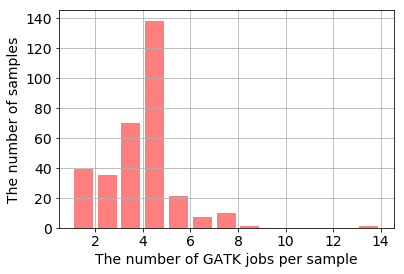

In [169]:
bins=np.arange(1,15,1)
hist, bin_edges = np.histogram(sample_qc_df.gatk,bins)
plt.hist(sample_qc_df.gatk, bins, rwidth = 0.8, color = 'red', alpha = 0.5)
print(hist)

plt.grid()
plt.xlabel('The number of GATK jobs per sample', fontsize = 14)
plt.ylabel('The number of samples', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

### Histogram for # of FQ2U jobs per sample

[  0   0   0  10   1   0   0 308   0   3   0   0   0]


(array([  0.,  50., 100., 150., 200., 250., 300., 350.]),
 <a list of 8 Text yticklabel objects>)

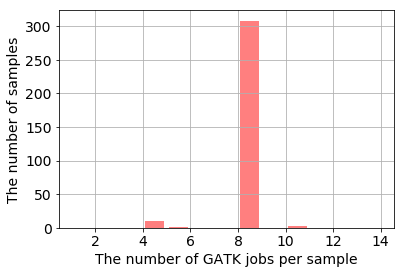

In [170]:
## bins=np.arange(1,15,1)
hist, bin_edges = np.histogram(sample_qc_df.fq2u,bins)
plt.hist(sample_qc_df.fq2u, bins, rwidth = 0.8, color = 'red', alpha = 0.5)
print(hist)

plt.grid()
plt.xlabel('The number of GATK jobs per sample', fontsize = 14)
plt.ylabel('The number of samples', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

### Histogram for # of UBAM jobs per sample

[  0   0   0 140 103  58  19   2   0   0   0   0   0]


(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 <a list of 9 Text yticklabel objects>)

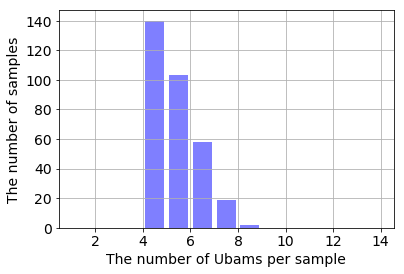

In [171]:
bins=np.arange(1,15,1)
hist, bin_edges = np.histogram(sample_qc_df.ubam,bins)
plt.hist(sample_qc_df.ubam, bins, rwidth = 0.8, color = 'blue', alpha = 0.5)
print(hist)

plt.grid()
plt.xlabel('The number of Ubams per sample', fontsize = 14)
plt.ylabel('The number of samples', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

[ 3  1  5 10  0  0  0  0  0  0  0  0  0]


(array([ 0., 10., 20., 30., 40., 50., 60.]),
 <a list of 7 Text yticklabel objects>)

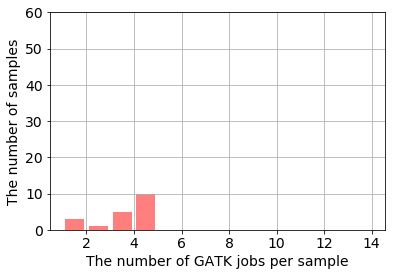

In [172]:
test=sample_qc_df[['ubam','gatk']].loc[sample_qc_df['ubam']==7]

bins=np.arange(1,15,1)
hist, bin_edges = np.histogram(test.gatk,bins)
plt.hist(test.gatk, bins, rwidth = 0.8, color = 'red', alpha = 0.5)
print(hist)

plt.grid()
plt.ylim((0,60))
plt.xlabel('The number of GATK jobs per sample', fontsize = 14)
plt.ylabel('The number of samples', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

808
[765   0   0   1   3  21  14   2   1   1]


(array([  0., 100., 200., 300., 400., 500., 600., 700., 800., 900.]),
 <a list of 10 Text yticklabel objects>)

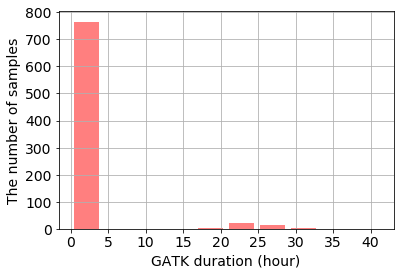

In [173]:
#query = "MATCH (j:Job:CromwellWorkflow) RETURN j.sample as sample, j.durationMinutes as duration"
#query = "MATCH (j:Job:CromwellWorkflow)-[:STATUS]->(s:Dstat) RETURN j.sample as sample, j.durationMinutes as duration"
query = "MATCH (j:Job:CromwellWorkflow)-[:STATUS]->(s:Dstat) WHERE not s.status='SUCCESS' RETURN j.sample as sample, j.durationMinutes as duration"
gatk_duration = graph.run(query).to_data_frame()
gatk_duration.set_index('sample')
print(len(gatk_duration))

hist, bin_edges = np.histogram(gatk_duration.duration)
plt.hist(gatk_duration.duration/60, rwidth = 0.8, color = 'red', alpha = 0.5)
print(hist)

plt.grid()
#plt.ylim((0,60))
plt.xlabel('GATK duration (hour)', fontsize = 14)
plt.ylabel('The number of samples', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

In [181]:
#query = "MATCH (j:Job:CromwellWorkflow) RETURN j.sample as sample, j.durationMinutes as duration"
#query = "MATCH (j:Job:CromwellWorkflow)-[:STATUS]->(s:Dstat) RETURN j.sample as sample, j.durationMinutes as duration"
query = "MATCH (j:Job:CromwellWorkflow) WHERE j.sample='SHIP4948767' RETURN j.sample as sample, j.startTime as startTime, j.stopTime as stopTime, j.durationMinutes as duration"
gatk_startTime_bySample = graph.run(query).to_data_frame()
gatk_startTime_bySample.set_index('sample')
gatk_startTime_bySample[['startTime','stopTime','duration']].sort_values(by=['startTime'])

,startTime,stopTime,duration
0,2019-12-12T02:36:31.987Z,2019-12-13T06:03:37.574Z,1647
1,2019-12-12T02:40:56.313Z,2019-12-12T02:57:28.299Z,16
2,2019-12-12T02:41:08.062Z,2019-12-12T02:57:27.483Z,16
3,2019-12-12T02:43:19.27Z,2019-12-12T02:57:26.598Z,14
4,2019-12-12T02:53:23.179Z,2019-12-12T02:56:22.01Z,2


In [182]:
#query = "MATCH (j:Job:CromwellWorkflow) RETURN j.sample as sample, j.durationMinutes as duration"
#query = "MATCH (j:Job:CromwellWorkflow)-[:STATUS]->(s:Dstat) RETURN j.sample as sample, j.durationMinutes as duration"
query = "MATCH (j:Job:CromwellWorkflow) WHERE j.sample='SHIP4948776' RETURN j.sample as sample, j.startTime as startTime, j.stopTime as stopTime, j.durationMinutes as duration"
gatk_startTime_bySample = graph.run(query).to_data_frame()
gatk_startTime_bySample.set_index('sample')
gatk_startTime_bySample[['startTime','stopTime','duration']].sort_values(by=['startTime'])

,startTime,stopTime,duration
0,2019-12-12T02:18:09.861Z,2019-12-12T21:35:51.143Z,1157
1,2019-12-12T02:20:03.16Z,2019-12-12T02:35:48.166Z,15
3,2019-12-12T02:39:09.135Z,2019-12-12T02:48:46.62Z,9
2,2019-12-12T02:43:14.854Z,2019-12-12T02:48:45.309Z,5
